In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()


In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1896ccb28d0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1896ccc50b8>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1}

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
first_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
first_date

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Create a variable for the last twelve months

precip = []

# Starting from the most recent data point in the database, calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23)
year_prior = query_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp, Measurement.station).filter(Measurement.date < query_date).filter(Measurement.date > year_prior).all()

# Append query data to the variable; look at the first 10 elements of the list of tubles
for data in last_year:
    precip.append(data)
precip[:10]

[('2016-08-24', 0.08, 'USC00519397'),
 ('2016-08-25', 0.08, 'USC00519397'),
 ('2016-08-26', 0.0, 'USC00519397'),
 ('2016-08-27', 0.0, 'USC00519397'),
 ('2016-08-28', 0.01, 'USC00519397'),
 ('2016-08-29', 0.0, 'USC00519397'),
 ('2016-08-30', 0.0, 'USC00519397'),
 ('2016-08-31', 0.13, 'USC00519397'),
 ('2016-09-01', 0.0, 'USC00519397'),
 ('2016-09-02', 0.0, 'USC00519397')]

In [14]:
# Save the query results as a Pandas DataFrame, set the index to the date column and sort the index
df = pd.DataFrame(precip, columns = ['date', 'precipitation', 'station']).set_index('date')
df.sort_index(inplace = True)
df.dropna(how = 'any', inplace = True)
df.head(5)

,precipitation,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00519281
2016-08-24,2.28,USC00514830
2016-08-24,2.15,USC00513117
2016-08-24,1.45,USC00516128


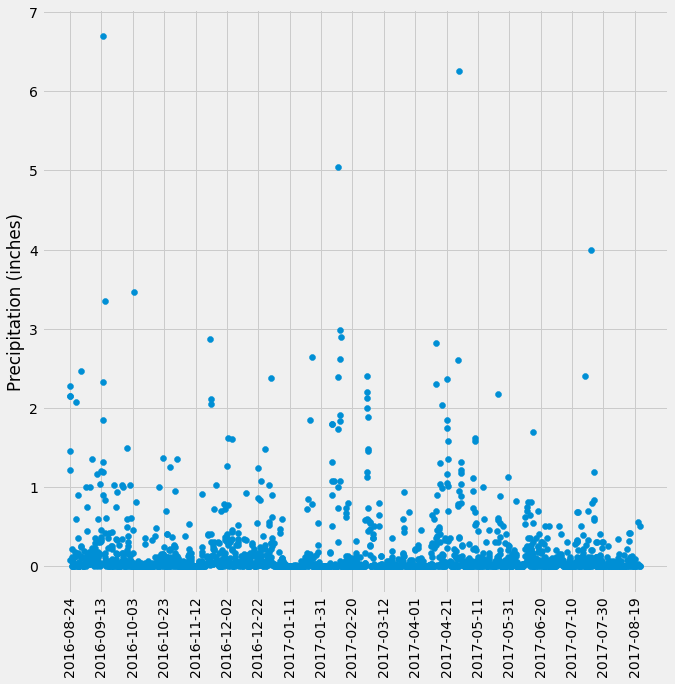

In [15]:
fig = plt.figure(figsize = (10,10))
x_values = df.index.values
y_values = df['precipitation']
plt.scatter(x_values,y_values)
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation = 90)
plt.xticks(np.arange(0, 365 +1, 20))
plt.show()
fig.savefig('Images/precipitation.png')

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
description = df['precipitation'].describe()
pd.DataFrame(description)

,precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'There are a total of {total_stations} weather stations in the data set')

There are a total of 9 weather stations in the data set


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = []
station_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(Measurement.tobs.desc()).all()

for data in station_tobs:
    stations.append(data)
print(stations)

 
station_highest_tobs = stations[0][0]

print(station_highest_tobs)

# Used a dataframe for better visualization

df_stations = pd.DataFrame(stations, columns = ['Station', 'Number of Observations']).sort_values('Number of Observations', ascending = False)

df_stations

[('USC00519523', 2669), ('USC00517948', 1372), ('USC00516128', 2612), ('USC00518838', 511), ('USC00519281', 2772), ('USC00514830', 2202), ('USC00513117', 2709), ('USC00511918', 1979), ('USC00519397', 2724)]
USC00519523


,Station,Number of Observations
4,USC00519281,2772
8,USC00519397,2724
6,USC00513117,2709
0,USC00519523,2669
2,USC00516128,2612
5,USC00514830,2202
7,USC00511918,1979
1,USC00517948,1372
3,USC00518838,511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'The lowest temperature at station USC00519281 is {low_temp[0][1]}F')

max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'The highest temperature at station USC00519281 is {max_temp[0][1]}F')

sum_temp = session.query(Measurement.station, func.sum(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
count_temp = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

avg_temp = sum_temp[0][1]/count_temp[0][1]

print(f'The average temperature at station USC00519281 is {avg_temp:.1f}F')

The lowest temperature at station USC00519281 is 54.0F
The highest temperature at station USC00519281 is 85.0F
The average temperature at station USC00519281 is 71.7F


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

yr_temps = []

# Starting from the most recent data point in the database, calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23)
year_prior = query_date - dt.timedelta(days=365)


# Perform a query to retrieve the dates and temperatures
one_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date < query_date).filter(Measurement.date > year_prior).filter(Measurement.station == 'USC00519281').all()
# Append query data to the variable; look at the first 10 elements of the list of tubles
for temps in one_year:
    yr_temps.append(temps)
yr_temps[:10]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0)]

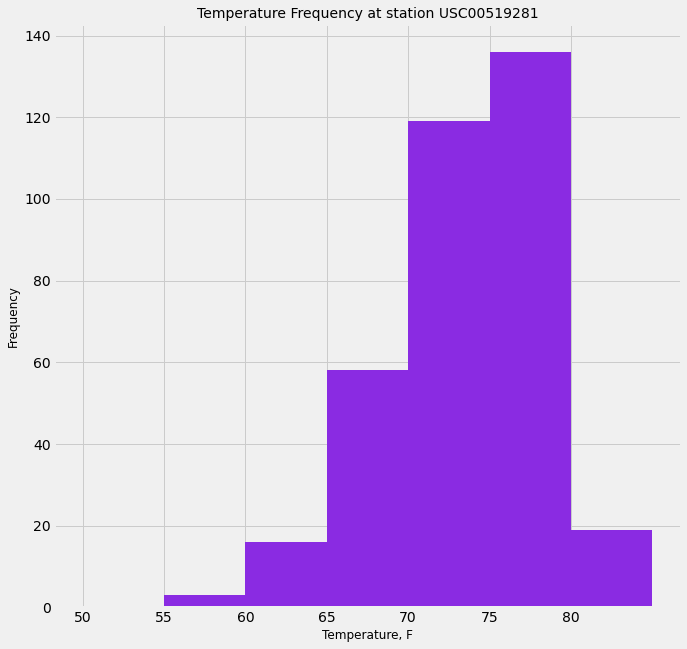

In [21]:
# Plot the results in a histogram

plt.close()
fig.clear()

# unpack the tuple to x and y values
x_values, y_values = zip(*yr_temps)

# choose bins based on min, max and average temperatures
bins = [50, 55, 60, 65, 70, 75, 80, 85]

fig = plt.figure(figsize = (10,10))
plt.hist(y_values, bins=bins, histtype='bar', align='mid', orientation='vertical', color='blueviolet')
plt.title('Temperature Frequency at station USC00519281', fontsize = 14)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Temperature, F', fontsize = 12)
plt.xticks(range(50, 85, 5))
fig.savefig('Images/temps_histogram')
# plt.close()
# fig.clear()

# Close session

In [22]:
# Close Session
session.close()